# Linux下功耗分析
基于Keysight 66319D和Trace进行功耗同步分析

# 1. 库、开关即变量
引用第三方库以及全局开关变量定义。

In [169]:
import csv
import os
import time
import visa
import matplotlib.pyplot as plt
import numpy as np
from threading import Thread
import threading
import pandas as pd
from prettytable import PrettyTable

import analyze_ftrace as aflib

get_ipython().magic(u'matplotlib inline') #Insert matplotlib output as embedded

#-------------------------------------------------------------------------------------------
#                      Global switch
#-------------------------------------------------------------------------------------------
aflib.sysvals.ftracefile = 'trace.txt' #As input of trace events
aflib.sysvals.csv_output_enable = False #Will dump the details of trace events

#Get data from file
get_data_from_file = True
#Enable debug info
debug_extra_info_enable = True

enable_power = True

#47 zx29_tick_irq
#66 zx29dma
#68 dwc_otg_pcd
#87 spi-nand
#108 uart-zx29
enable_irq = True
filter_irq = ['spi-nand', 'zx29_tick_irq', 'uart-zx29', 'zx29dma'] #Move filter function to filter.sh for temp

enable_wakeup = True
filter_wakeup = ['nand'] #Move filter function to filter.sh for temp

enable_cpuidle = True

enable_cpufreq = True

#-------------------------------------------------------------------------------------------
#                      Global variable
#-------------------------------------------------------------------------------------------
plot_index = 0
power_values = []

csv_summary = 'summary.csv'
stop_capture = False

trace_lock = threading.Lock()
power_lock = threading.Lock()
trace_measure_start = 0.0
trace_measure_end = 0.0
power_measure_start = 0.0
power_measure_end = 0.0

# 2. 获取测试数据
读取直流电源数据和抓取Trace events两个子线程。

## 2.1 获取Trace events
此线程用于获取Kernel Trace events，需要和获取功耗线程进行同步。

问题列表：

<span class="mark">1. USB-ADB接口进入充电模式，导致仪表读数为负。</span><span class="girk">改成串口通信</span>

<span class="mark">2. 串口传输文件问题</span>

<span class="mark">3. 进入suspend之后，串口输入需要先唤醒</span>

<span class="mark">4. PC记录trace_measure_start，之后没有同时Trace打印。</span><span class="girk">主动往trace_marker写入CAPTURE_START/CAPTURE_END</span>

<span class="mark">5. 开关机编程</span>

<span class="mark">6. USB开关编程</span>


In [170]:
#-------------------------------------------------------------------------------------------
#                     class TraceThread by ADB
#-------------------------------------------------------------------------------------------
class TraceThread(Thread):
    """
    A threading example
    """

    #----------------------------------------------------------------------
    def __init__(self, name):
        """Initialize the thread"""
        Thread.__init__(self)
        self.name = name
        self.start()

    #----------------------------------------------------------------------
    def run(self):
        """Run the thread"""
        global trace_lock
        global power_lock
        global trace_measure_start
        global trace_measure_end

        trace_events = []

        trace_events += ['/power/machine_suspend']

        if enable_irq:
            trace_events += ['/irq/irq_handler_entry', '/irq/irq_handler_exit']

        if enable_wakeup:
            trace_events += ['/power/wakeup_source_activate', '/power/wakeup_source_deactivate']

        if enable_cpuidle:
            trace_events += ['/power/cpu_idle']

        if enable_cpufreq:
            trace_events += ['/power/cpu_frequency']

        while True:
            result = os.popen('adb devices')
            text = result.read()
            if '1234567890ABCDEF' in text:
                print 'Devices 1234567890ABCDEF connected'
                break
            else:
                print 'Please connect devices'
            time.sleep(1)

        os.popen('adb shell \"echo 0 >/sys/kernel/debug/tracing/tracing_on\"')  #Turn off tracing
        os.popen('adb shell \"echo 0 >/sys/kernel/debug/tracing/events/enable\"')  #Disable all traceevents
        os.popen('adb shell \"echo > /sys/kernel/debug/tracing/trace\"')  #Clear trace buffer

        #Enable power related trace events
        for i in trace_events:
            result = os.popen('adb shell \"echo 1 >/sys/kernel/debug/tracing/events'+i+'/enable\"')

        #Set tracing buffer size
        os.popen('adb shell \"echo 4096 >/sys/kernel/debug/tracing/buffer_size_kb\"')

        #Move filter function to filter.sh for temp
        os.popen('adb push filter.sh /')
        os.popen('adb shell sh filter.sh')

        power_lock.release() #Release power_lock to unlock power thread

        #Turn on tracing
        trace_measure_start = time.time()*1000
        os.popen('adb shell \"echo 1 >/sys/kernel/debug/tracing/tracing_on\"')
        
        #IMPORTANT! Make sure sync between tracemeasure_start and trace timestamp
        os.popen('adb shell \"echo CAPTURE_START >/sys/kernel/debug/tracing/trace_marker\"')

        trace_lock.acquire() #Wait for power thread to release trace_lock, then stop capturing trace
        while True:
            result = os.popen('adb devices')
            text = result.read()
            if '1234567890ABCDEF' in text:
                print 'Devices 1234567890ABCDEF connected'
                break
            else:
                print 'Please connect devices'
            time.sleep(0.5)

        #Save trace evnts
        os.popen('adb shell \"echo CAPTURE_END >/sys/kernel/debug/tracing/trace_marker\"')
        os.popen('adb shell \"echo 0 >/sys/kernel/debug/tracing/events/enable\"')  #Disable all traceevents
        trace_measure_end = time.time()*1000
        print 'Trace ending(host): %.3f ms' % (trace_measure_end-trace_measure_start)
        os.popen('adb shell \"cat /sys/kernel/debug/tracing/trace > /trace.txt\"')

        #Pull trace log
        os.popen('adb pull trace.txt')
        trace_lock.release()

## 2.2 获取功耗数据
获取功耗数据，以及获取功耗值时的时间戳。

问题列表：

<span class="mark">1. 目前采样精度12ms左右，更高精度？</span>

In [171]:
#-------------------------------------------------------------------------------------------
#                     class PowerThread
#-------------------------------------------------------------------------------------------
class PowerThread(Thread):
    """
    A threading example
    """

    #----------------------------------------------------------------------
    def __init__(self, name):
        """Initialize the thread"""
        Thread.__init__(self)
        self.name = name
        self.data_array = []
        self.start()
 
    #----------------------------------------------------------------------
    def run(self):
        """Run the thread"""
        global trace_lock
        global power_lock
        global power_measure_start
        global power_measure_end

        rm = visa.ResourceManager()
        res = rm.list_resources()

        inst = rm.open_resource(res[-1])

        #Set the power supply output
        inst.write("INST P6V") # Select +6V output
        inst.write("VOLT 3.8") # Set output voltage to 3.8 V
        inst.write("CURR 2.0") # Set output current to 2.0 A

        # Power off then power on, delay 1 second for stable
        inst.write("OUTP OFF")
        inst.write("OUTP ON")
        time.sleep(0.5)

        inst.timeout = 6000
        #Sample rate and count
        #inst.write('SENS:SWE:TINT 15.6E-6')
        inst.write('SENS:SWE:POIN 64')
        #inst.write('SENS:WIND:RECT')

        power_lock.acquire() #Wait for trace thread to release power_lock
        power_measure_start = time.time()*1000
        while True:
            start = (time.time()*1000 - power_measure_start)
            if stop_capture:
                break
            current = inst.query_ascii_values('MEAS:CURR?', container=np.array)*1000
            if current < 0:
                print current
            self.data_array.append({'start':start, 'current':current})
        power_measure_end = time.time()*1000
        print 'Power(%d) ending(host): %.3f ms, average:%.3f' % (len(self.data_array), (power_measure_end-power_measure_start), (power_measure_end-power_measure_start)/len(self.data_array))

        #inst.write("OUTP OFF")
        power_lock.release()

# 3. 功耗和Trace的分析与输出
从Trace线程和Power线程获取数据，然后进行分析，最后输出图表和总结。

## 3.1 抓取Trace和Power数据

In [172]:
#================================Capture ftrace and power=================================================
if get_data_from_file:
    csvfile_power = open('power.csv', 'rb')
    csv_reader_power = csv.reader(csvfile_power)
    for i in csv_reader_power:
        power_values.append({'start':float(i[0]),'current':float(i[1])})
    csvfile_power.close()
    data = aflib.parseFtraceLog()
else:
    trace_lock.acquire()
    power_lock.acquire()

    rm = visa.ResourceManager()
    while True:
        res = rm.list_resources()
        if res:
            break
        else:
            print 'Please power on 66319D'
        time.sleep(5)

    power_thread = PowerThread(name='PowerThread')

    trace_thread = TraceThread(name='TraceThread')

    if(raw_input('y to stop:') == 'y'):
        while True:
            result = os.popen('adb devices')
            text = result.read()
            if '1234567890ABCDEF' in text:
                stop_capture = True
                break
            else:
                print 'Please connect devices'
            time.sleep(0.5)
    time.sleep(2)
    trace_lock.acquire() #Wait for trace thread to finish
    power_lock.acquire() #Wait for power thread to finish
    
    power_values = power_thread.data_array
    data = aflib.parseFtraceLog()

    #Read power data from Keysight 66319D
    power_to_trace_offset = data.start +power_measure_start - trace_measure_start
    #print power_to_trace_offset
    for i in power_values:
        i['start'] += power_to_trace_offset
    csvfile_power = open('power.csv', 'wb')
    csvwriter_power = csv.writer(csvfile_power)
    for i in power_values:
        csvwriter_power.writerow([i['start'], i['current']])
    csvfile_power.close()
#=========================================================================================================

data_length = data.end - data.start
print 'Trace duration(guest):', data_length, ' ms'


Trace duration(guest): 934008.545  ms


## 3.2 分析数据生成图表

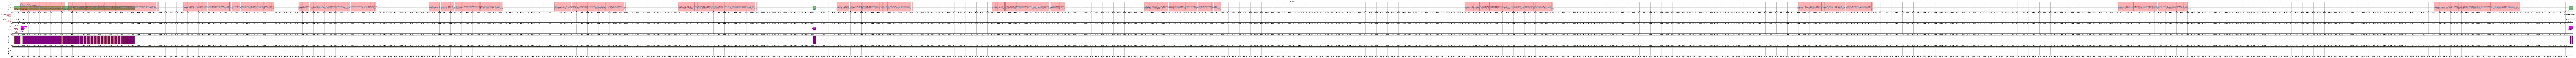

In [173]:
fig, ax = plt.subplots()
xticks = range(int(data.start/1000)*1000, int(data.end/1000)*1000, 2000)


#================================Draw power data==========================================================
def power_data_analyze(power_data):
    total_power = 0.0
    high_start = 0.0
    high_count = 0
    high_power = 0.0
    high_threshhold = 40.0 #if current is higher than high_threshhold
    high_point = []

    for i in range(len(power_data) - 2):
        total_power +=  (power_data[i+1]['start'] - power_data[i]['start'])*power_data[i]['current']
        if(power_data[i]['current'] > high_threshhold):
            if(high_start == 0.0):
                high_start = power_data[i]['start']
            high_count+=1
            high_power += (power_data[i+1]['start'] - power_data[i]['start'])*power_data[i]['current']
        else:
            if(high_count >= 20):
                high_point.append({'start':high_start, 'duration':(power_data[i]['start']-high_start), 'capacity':high_power})
            high_count = 0
            high_power = 0.0
            high_start = 0.0

    average_current = total_power/(power_data[len(power_data)-2]['start'] - power_data[0]['start'])
    total_power /= 3600 

    return high_point, total_power, average_current

if enable_power:
    plot_index += 1
    ax_run = plt.subplot(6, 1, plot_index)

    axes_x = []
    axes_y = []

    high_point, total_power, average_current = power_data_analyze(power_values)

    #highlight high power area, show the consumption and average current
    for i in high_point:
        plt.axvspan(i['start'], i['start']+i['duration'], ymin=0, ymax=1, color='red', alpha=0.3)
        if debug_extra_info_enable:
            plt.text(i['start']+i['duration']/2, i['capacity']/i['duration']-15, '%.3f mA' % (i['capacity']/i['duration']), color='red', fontsize=6)
            plt.text(i['start']+i['duration']/2, i['capacity']/i['duration']+15, '%.3f uAH' % (i['capacity']/3600), color='red', fontsize=6)


    plt.annotate('Capacity: '+('%.3f' % total_power)+' uAH', xy=(power_values[0]['start'], 5), xytext=(power_values[0]['start'], 5), color='red')
    plt.annotate('Average: '+('%.3f' % average_current)+' mA', xy=(power_values[0]['start'], 55), xytext=(power_values[0]['start'], 55), color='red')

    if data.run:
        running = []
        broken_bar_y = 0
        broken_bar_height = 150
        for line in data.run:
            running.append([float(line['start']), line['duration']])

        plt.broken_barh(running, (broken_bar_y, broken_bar_height), facecolor='green', linewidth=0.1, alpha=0.6)
    for i in power_values:
        axes_x.append(i['start'])
        axes_y.append(i['current'])	
    plt.plot(axes_x, axes_y, linewidth=0.3)
    plt.xlabel('time(ms)')
    plt.xlim(data.start, data.end)
    plt.ylim(-50,)
    plt.ylabel('current(mA)')
    plt.title('K318 PM')
    plt.grid(True)
    ax_run.set_xticks(xticks)

#================================Draw irq data==========================================================

if enable_irq:
    plot_index += 1
    ax_run = plt.subplot(6, 1, plot_index)

    irq_bar_height = 0.2

    irq = dict()
    irq_keys = []
    irq_min = 0.0
    for line in data.irq:
        if line['name'] not in irq_keys:
            irq_keys.append(line['name'])
            irq[line['name']] = []
        irq[line['name']].append([line['start'], line['duration']])
        if irq_min == 0.0:
            irq_min = line['start']
        elif(irq_min > line['start']):
            irq_min = line['start']
    for i in irq_keys:
        plt.broken_barh(irq[i], (irq_bar_height*(irq_keys.index(i)), irq_bar_height), facecolor='purple', linewidth=0.1)
        plt.text(irq_min - 1000, irq_bar_height*(irq_keys.index(i)) + irq_bar_height/2, i, horizontalalignment='right', verticalalignment='center', color='red', fontsize=8)
        if debug_extra_info_enable:
            for j in irq[i]:
                if(j[1] > 1):
                    plt.text(j[0]+j[1]/2, irq_bar_height*(irq_keys.index(i)) + irq_bar_height/2, str(i), horizontalalignment='center', verticalalignment='center', fontsize=8)
    ax.set_yticklabels(irq_keys)
    plt.ylabel('irq')
    plt.grid(True)
    plt.xlim(data.start, data.end)
    ax_run.set_xticks(xticks)

#================================Draw wakesource data==========================================================

if enable_wakeup:
    plot_index += 1
    ax_run = plt.subplot(6, 1, plot_index)


    wakeup_bar_height = 0.2
    wakeup = dict()
    wakeup_keys = []
    wakeup_min = 0.0
    for line in data.wakesource:
        if line['name'] not in wakeup_keys:
            wakeup_keys.append(line['name'])
            wakeup[line['name']] = []
        wakeup[line['name']].append([line['start'], line['duration']])
        if wakeup_min == 0.0:
            wakeup_min = line['start']
        elif(wakeup_min > line['start']):
            wakeup_min = line['start']

    for i in wakeup_keys:
        plt.broken_barh(wakeup[i], (wakeup_bar_height*(wakeup_keys.index(i)), wakeup_bar_height), facecolor='magenta', linewidth=0.1)
        plt.text(wakeup_min - 1000, wakeup_bar_height*(wakeup_keys.index(i)) + wakeup_bar_height/2, i, horizontalalignment='right', verticalalignment='center', color='red', fontsize=8)
        if debug_extra_info_enable:
            for j in wakeup[i]:
                if(j[1] > 10):
                    plt.text(j[0]+j[1]/2, wakeup_bar_height*(wakeup_keys.index(i)) + wakeup_bar_height/2, str(i), horizontalalignment='center', verticalalignment='center', fontsize=8)
    plt.ylabel('wakeup')
    plt.grid(True)
    plt.xlim(data.start, data.end)
    ax_run.set_xticks(xticks)

#================================Draw cpufidle data==========================================================

if enable_cpuidle:
    plot_index += 1
    ax_run = plt.subplot(6, 1, plot_index)


    cpuidle_wfi = []
    cpuidle_off = []
    for line in data.cpuidle:
        if line['state'] == 'WFI':
            cpuidle_wfi.append([line['start'], line['duration']])
        elif line['state'] == 'OFF':
            cpuidle_off.append([line['start'], line['duration']])

    plt.broken_barh(cpuidle_wfi, (1, 0.2), facecolor='yellow', linewidth=0.1)
    plt.broken_barh(cpuidle_off, (1, 0.2), facecolor='purple', linewidth=0.1)

    plt.ylabel('cpuidle(WFI/OFF)')
    plt.xlim(data.start, data.end)
    ax_run.set_xticks(xticks)

#================================Draw cpufreq data==========================================================

if enable_cpufreq:
    plot_index += 1
    ax_run = plt.subplot(6, 1, plot_index)

    axes_x = []
    axes_y = []
    for line in data.cpufreq:
        axes_x.append(line['start'])
        axes_y.append(line['freq']/1000)

    plt.step(axes_x, axes_y, '--', label='cpufreq', where='post')
    for i in range(len(axes_x)):
        plt.text(axes_x[i], axes_y[i], str(axes_y[i])+'M', horizontalalignment='center', fontsize=8)

    plt.ylabel('cpufreq(Mhz)')
    plt.grid(True)
    plt.xlim(data.start, data.end)
    ax_run.set_xticks(xticks)

#================================Draw figure================================================================
plt.show
fig = plt.gcf()
fig.set_size_inches(data_length/2000, 12)
fig.savefig('power.svg', format='svg', dpi=data_length/1000, bbox_inches='tight')


## 3.3 输出统计信息
统计各子项的详细信息，有助于发现问题。

### 3.3.1 功耗统计
Capacity: 测试周期内总消耗量，单位毫安时

Average: 测试周期内平均电流，单位毫安

In [174]:
#Summary of Power
table_power = PrettyTable()
table_power.field_names = ['Item', 'Value']
table_power.add_row(['Capaticy(uAH)', total_power])
table_power.add_row(['Average(mA)', average_current])
print table_power

+---------------+---------------+
|      Item     |     Value     |
+---------------+---------------+
| Capaticy(uAH) | 12298.9198494 |
|  Average(mA)  | 47.4202646877 |
+---------------+---------------+


### 3.3.2 唤醒状态统计
记录何时唤醒(start)以及唤醒多久(duration)。

In [175]:
#Summary of suspend/resume
table_run = PrettyTable()
table_run.field_names = ['start(ms)', 'duration(ms)']
for i in data.run:
    table_run.add_row([i['start'], i['duration']])
print table_run

+------------+--------------+
| start(ms)  | duration(ms) |
+------------+--------------+
| 17717.407  |  44202.942   |
| 309341.278 |   1043.091   |
| 950184.906 |     1541     |
+------------+--------------+


### 3.3.3 中断统计信息
统计每个中断例程执行的时长，通过这些可以发现中断上半部问题(max/mean/std)，以及中断频繁程度(count)。

mean：平均值；max：最大值；min：最小值；count：中断数；sum：中断总耗时；std：耗时均方差。

In [176]:
#Summary of irq
if enable_irq:
    table_irq = PrettyTable()
    table_irq.field_names = ['name', 'mean', 'max', 'min', 'count', 'sum', 'std']
    for i in irq_keys:
        irq_statistics = np.array(irq[i])
        table_irq.add_row([str(i), '%.3f' % irq_statistics[:, 1].mean(), irq_statistics[:, 1].max(), irq_statistics[:, 1].min(), irq_statistics[:, 1].size, irq_statistics[:, 1].sum(),irq_statistics[:, 1].std()])
    print table_irq    


+------------------------+-------+--------+-------+-------+--------+------------------+
|          name          |  mean |  max   |  min  | count |  sum   |       std        |
+------------------------+-------+--------+-------+-------+--------+------------------+
|      dwc_otg_pcd       | 0.457 | 32.196 |  0.0  |  104  | 47.516 |  3.26191450776   |
|        zx29dma         | 0.004 | 0.031  |  0.0  |  675  | 2.903  | 0.0106282606939  |
|  dwc_otg_powerdown_up  | 7.644 |  7.66  | 7.629 |   2   | 15.289 |      0.0155      |
|         icp_ps         | 0.006 | 0.031  |  0.0  |   5   | 0.031  |      0.0124      |
|       zx29_i2c.0       | 0.010 | 0.031  |  0.0  |   48  | 0.459  | 0.0141861232812  |
|       wake_timer       | 0.003 | 0.092  |  0.0  |  1378 | 4.305  | 0.00947335198132 |
| dwc_otg_powerdown down | 5.264 |  6.5   | 4.028 |   2   | 10.528 |      1.236       |
+------------------------+-------+--------+-------+-------+--------+------------------+


### 3.3.4 唤醒源统计
统计唤醒源保持时间，发现是谁导致系统保持唤醒状态。

mean：平均值；max：最大值；min：最小值；count：中断数；sum：中断总耗时；std：耗时均方差。

In [177]:
#Summary of wakesource
if enable_wakeup:
    table_wakeup = PrettyTable()
    table_wakeup.field_names = ['name', 'mean', 'max', 'min', 'count', 'sum', 'std']
    for i in wakeup_keys:
        wakeup_statistics = np.array(wakeup[i])
        table_wakeup.add_row([str(i), '%.3f' % wakeup_statistics[:, 1].mean(), wakeup_statistics[:, 1].max(), wakeup_statistics[:, 1].min(), wakeup_statistics[:, 1].size, wakeup_statistics[:, 1].sum(),wakeup_statistics[:, 1].std()])
    print table_wakeup

+----------------+----------+----------+---------+-------+----------+---------------+
|      name      |   mean   |   max    |   min   | count |   sum    |      std      |
+----------------+----------+----------+---------+-------+----------+---------------+
|    zx29-i2c    |  0.681   |  14.923  |  0.122  |   32  |  21.786  | 2.56556512339 |
| usbcfgmng_lock | 124.664  | 124.664  | 124.664 |   1   | 124.664  |      0.0      |
|    icp_msg     | 1000.743 | 1002.961 | 999.482 |   3   | 3002.229 | 1.57326560589 |
|   wakeup_irq   | 1174.876 | 1516.052 | 999.451 |   3   | 3524.628 | 241.280188164 |
|   dwc_otg_pm   | 1094.177 | 2002.838 | 199.707 |   3   | 3282.531 | 736.193538481 |
|    rtc_lock    |  0.244   |  0.244   |  0.244  |   1   |  0.244   |      0.0      |
+----------------+----------+----------+---------+-------+----------+---------------+


### 3.3.5 CPU频率
统计频率切换时间以及频率值。

In [178]:
#Summary of cpufreq
if enable_cpufreq:
    table_cpufreq = PrettyTable()
    table_cpufreq.field_names = ['start', 'freq']
    for i in data.cpufreq:
        table_cpufreq.add_row([i['start'], i['freq']])
    print table_cpufreq

+------------+--------+
|   start    |  freq  |
+------------+--------+
| 29841.522  | 312000 |
| 61859.894  | 624000 |
| 309365.387 | 312000 |
| 310324.127 | 624000 |
| 950204.895 | 312000 |
| 950318.329 | 624000 |
| 950892.639 | 312000 |
+------------+--------+


### 3.3.6 保存到summary.csv

In [179]:
file_summary = open(csv_summary, 'wb')
writer_summary = csv.writer(file_summary)

#Summary of Power
writer_summary.writerow(['POWER'])
writer_summary.writerow(['Capacity:', str(total_power)+' uAH'])
writer_summary.writerow(['Average:', str(average_current)+' mA'])

#Summary of suspend/resume
writer_summary.writerow('')
writer_summary.writerow(['RUN'])
writer_summary.writerow(['start(ms)', 'duration(ms)'])
for i in data.run:
	writer_summary.writerow([i['start'], i['duration']])

#Summary of irq
if enable_irq:
    writer_summary.writerow('')
    writer_summary.writerow(['IRQ'])
    writer_summary.writerow(['name', 'mean', 'max', 'min', 'count', 'sum', 'std'])
    for i in irq_keys:
        irq_statistics = np.array(irq[i])
        writer_summary.writerow([str(i), '%.3f' % irq_statistics[:, 1].mean(), irq_statistics[:, 1].max(), irq_statistics[:, 1].min(), irq_statistics[:, 1].size, irq_statistics[:, 1].sum(),irq_statistics[:, 1].std()])

#Summary of wakesource
if enable_wakeup:
    writer_summary.writerow('')
    writer_summary.writerow(['Wakesource'])
    writer_summary.writerow(['name', 'mean', 'max', 'min', 'count', 'sum', 'std'])
    for i in wakeup_keys:
        wakeup_statistics = np.array(wakeup[i])
        writer_summary.writerow([str(i), '%.3f' % wakeup_statistics[:, 1].mean(), wakeup_statistics[:, 1].max(), wakeup_statistics[:, 1].min(), wakeup_statistics[:, 1].size, wakeup_statistics[:, 1].sum(),wakeup_statistics[:, 1].std()])

#Summary of cpufreq
if enable_cpufreq:
    writer_summary.writerow('')
    writer_summary.writerow(['Frequency'])
    writer_summary.writerow(['start', 'freq'])
    for i in data.cpufreq:
        writer_summary.writerow([i['start'], i['freq']])

file_summary.close()